In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import TRANVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
label_ratio = 0.7

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'


tranvae_epochs = 500
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_normalized.h5ad'))
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

In [7]:
idx = np.arange(len(target_adata))
np.random.shuffle(idx)
n_labeled = int(label_ratio*len(target_adata))
labeled_ind = idx[:n_labeled]

In [8]:
print(target_adata.obs[condition_key][labeled_ind].unique().tolist())
print(target_adata.obs[condition_key][~labeled_ind].unique().tolist())
print(target_adata.obs[cell_type_key][labeled_ind].unique().tolist())
print(target_adata.obs[cell_type_key][~labeled_ind].unique().tolist())

['Pancreas CelSeq2', 'Pancreas SS2']
['Pancreas SS2', 'Pancreas CelSeq2']
['Pancreas Gamma', 'Pancreas Acinar', 'Pancreas Alpha', 'Pancreas Stellate', 'Pancreas Ductal', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Endothelial']
['Pancreas Ductal', 'Pancreas Acinar', 'Pancreas Gamma', 'Pancreas Delta', 'Pancreas Alpha', 'Pancreas Beta', 'Pancreas Stellate', 'Pancreas Endothelial']


In [9]:
load_path = os.path.expanduser(f'~/Documents/aaa_dev_mars/pancreas_testing/reference_03/')
tranvae = scarches.models.TRANVAE.load_query_data(
    adata=target_adata,
    reference_model = f'{load_path}reference_model/',
    labeled_indices=labeled_ind,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [10]:
tranvae.model.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas CelSeq2': 3,
 'Pancreas SS2': 4}

In [11]:
print(tranvae.model.landmarks_labeled)
print(tranvae.model.landmarks_unlabeled)

[[-0.34  0.05 -0.23 -1.03  0.56 -0.03  0.01 -0.1  -0.34 -0.16]
 [-0.33  0.04 -0.23 -1.01  0.55 -0.04  0.01 -0.11 -0.38 -0.17]
 [-0.19 -0.05 -0.24  0.55  0.71  1.04 -0.59  0.37 -0.14  0.41]
 [-0.25  0.08 -0.24 -0.35 -0.33  0.77  0.34  1.72 -0.34  0.52]
 [-0.35  0.1  -0.11 -0.99  0.58 -0.01  0.04 -0.09 -0.36 -0.19]
 [-0.23  0.02 -0.2   0.03  0.31 -0.19 -0.05  0.37 -0.25  0.25]
 [-0.33  0.11 -0.23  0.05  0.32 -1.08  1.69  0.53 -0.21  0.76]
 [-0.1   0.02 -0.23 -0.31  1.19  0.8   1.28  0.47 -0.11  1.44]]
[[-0.34  0.03 -0.17  0.18 -0.6   0.68  0.8  -0.57 -0.32  0.92]
 [-0.08  0.03 -0.23 -0.32  1.22  0.85  1.3   0.47 -0.11  1.48]
 [-0.19  0.02 -0.21  0.32 -0.26 -1.51 -0.32  0.64 -0.32  0.24]
 [-0.23  0.08 -0.24 -0.36 -0.35  0.79  0.35  1.77 -0.33  0.52]
 [-0.32  0.04 -0.31 -0.43  0.33 -0.58 -0.6   0.34 -0.21  1.96]
 [-0.19 -0.07 -0.23  0.59  0.72  1.08 -0.61  0.37 -0.13  0.41]
 [-0.33  0.07 -0.2  -1.05  0.57 -0.03  0.02 -0.12 -0.37 -0.19]
 [-0.33  0.11 -0.23  0.06  0.32 -1.09  1.71  0.53 -0.2

In [12]:
tranvae.model.new_landmarks

[]

In [13]:
surgery_epochs=500
tranvae.train(
    n_epochs=surgery_epochs,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=1000,
    tau=0,
    weight_decay=0
)

 |███████████████-----| 79.4%  - epoch_loss: 2766.97 - epoch_trvae_loss: 2400.05 - epoch_classifier_loss:  366.91 - epoch_unlabeled_loss:    0.07 - epoch_labeled_loss:    0.29 - val_loss: 3076.41 - val_trvae_loss: 2611.95 - val_classifier_loss:  464.46 - val_unlabeled_loss:    0.12 - val_labeled_loss:    0.352812847
ADJUSTED LR
 |█████████████████---| 85.6%  - epoch_loss: 2792.95 - epoch_trvae_loss: 2421.43 - epoch_classifier_loss:  371.52 - epoch_unlabeled_loss:    0.08 - epoch_labeled_loss:    0.29 - val_loss: 2895.68 - val_trvae_loss: 2565.83 - val_classifier_loss:  329.84 - val_unlabeled_loss:    0.07 - val_labeled_loss:    0.26
ADJUSTED LR
 |█████████████████---| 87.0%  - epoch_loss: 2762.46 - epoch_trvae_loss: 2387.53 - epoch_classifier_loss:  374.93 - epoch_unlabeled_loss:    0.07 - epoch_labeled_loss:    0.30 - val_loss: 2978.18 - val_trvae_loss: 2614.08 - val_classifier_loss:  364.10 - val_unlabeled_loss:    0.08 - val_labeled_loss:    0.29
Stopping early: no improvement of mo

In [14]:
adata_latent = sc.AnnData(tranvae.get_latent())
adata_latent.obs['celltype'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()
adata_latent.obs['predictions'] = tranvae.classify()

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


[<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

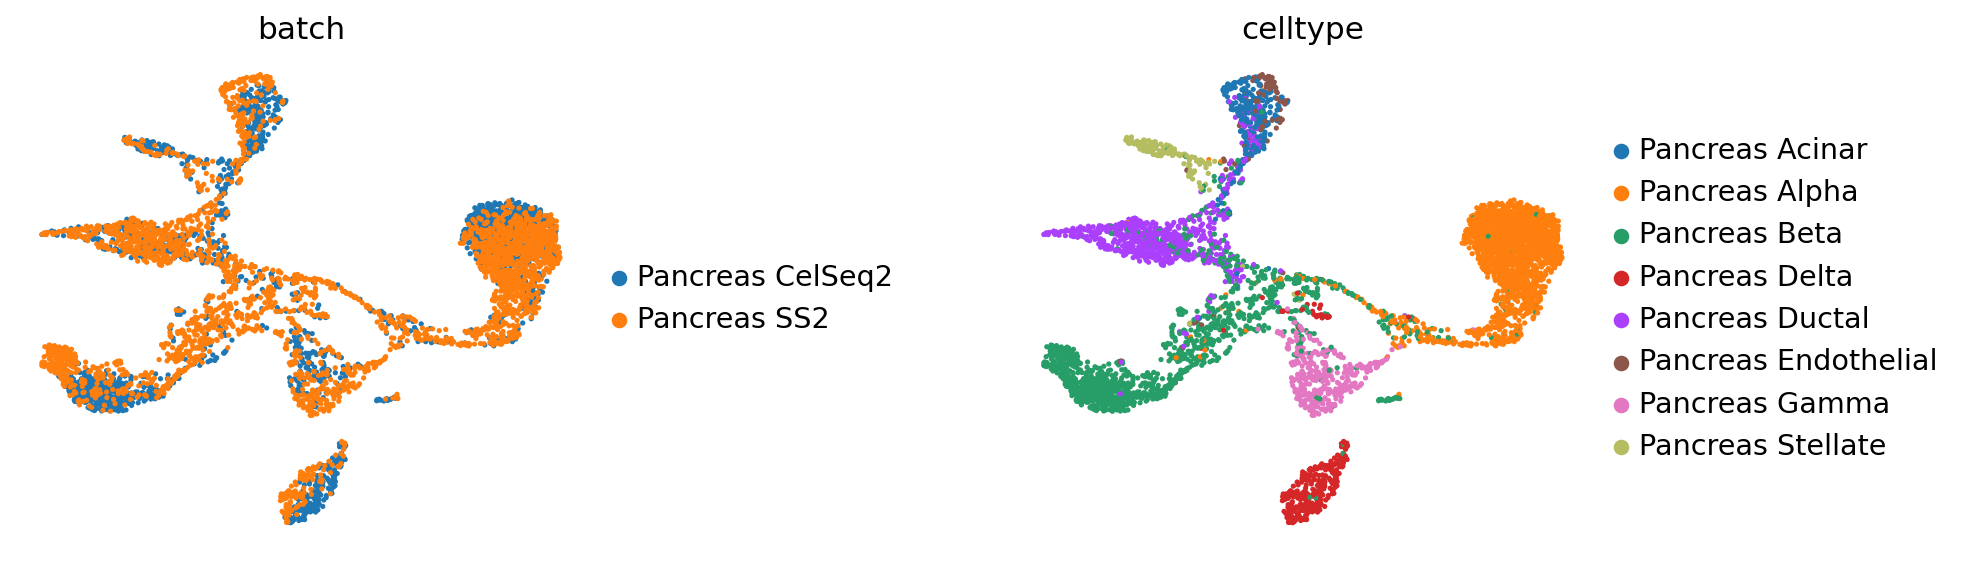

In [15]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [16]:
print("Acc: {}".format(np.mean(adata_latent.obs.predictions == adata_latent.obs.celltype)))

Acc: 0.8815667347317616


In [17]:
full_latent = sc.AnnData(tranvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['celltype'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obs['predictions'] = tranvae.classify(adata.X, adata.obs[condition_key])

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


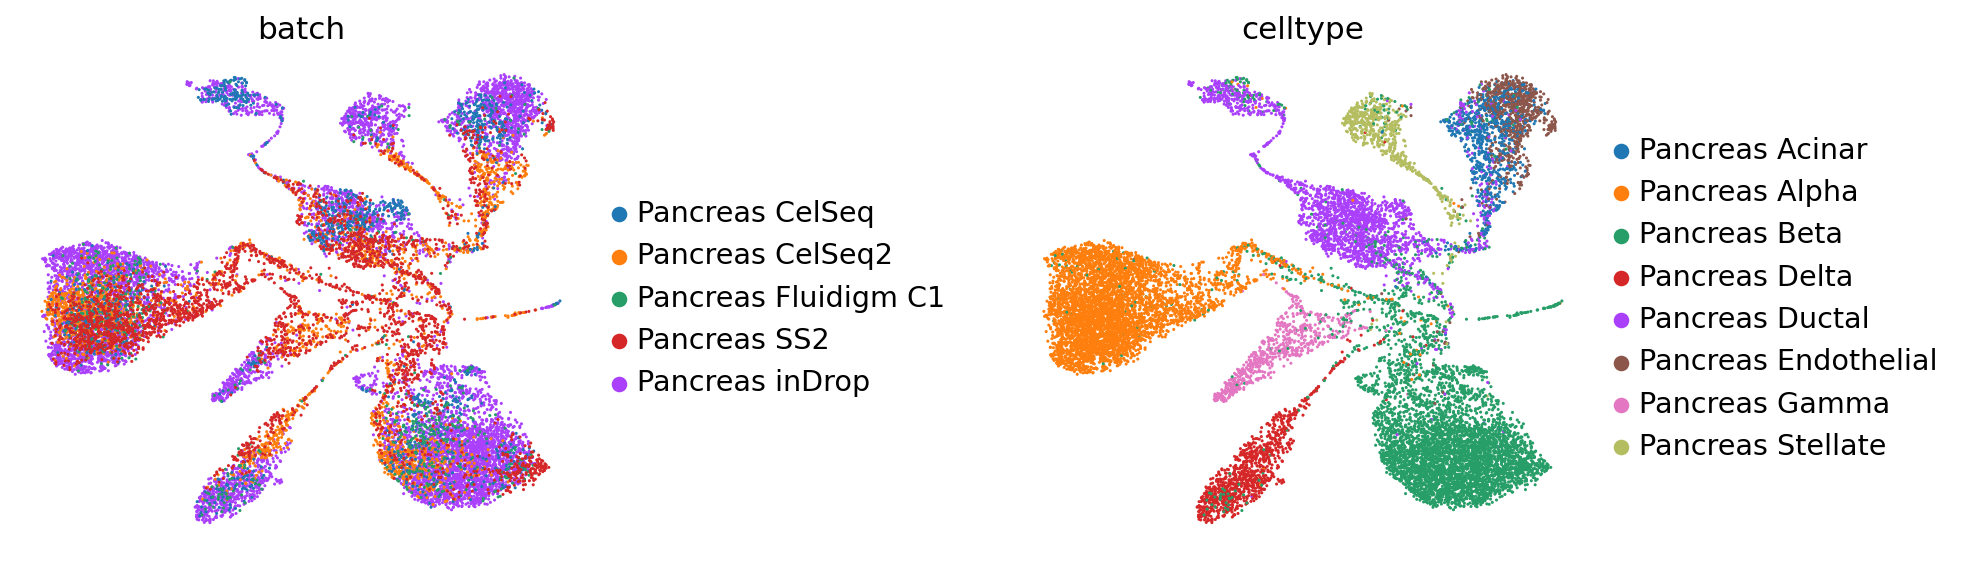

In [18]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           )

In [19]:
print("Acc: {}".format(np.mean(full_latent.obs.predictions == full_latent.obs.celltype)))

Acc: 0.9172246667942096


In [20]:
print(tranvae.landmarks_labeled_)
print(tranvae.landmarks_unlabeled_)

[[-0.34  0.05 -0.23 -1.03  0.56 -0.03  0.01 -0.1  -0.34 -0.16]
 [-0.33  0.04 -0.23 -1.01  0.55 -0.04  0.01 -0.11 -0.38 -0.17]
 [-0.19 -0.05 -0.24  0.55  0.71  1.04 -0.59  0.37 -0.14  0.41]
 [-0.25  0.08 -0.24 -0.35 -0.33  0.77  0.34  1.72 -0.34  0.52]
 [-0.35  0.1  -0.11 -0.99  0.58 -0.01  0.04 -0.09 -0.36 -0.19]
 [-0.23  0.02 -0.2   0.03  0.31 -0.19 -0.05  0.37 -0.25  0.25]
 [-0.33  0.11 -0.23  0.05  0.32 -1.08  1.69  0.53 -0.21  0.76]
 [-0.1   0.02 -0.23 -0.31  1.19  0.8   1.28  0.47 -0.11  1.44]]
[[-0.21  0.02 -0.2   0.03  0.35 -0.15 -0.07  0.35 -0.28  0.23]
 [-0.33  0.09 -0.23  0.06  0.33 -1.03  1.66  0.52 -0.22  0.76]
 [-0.19 -0.06 -0.24  0.52  0.69  0.97 -0.52  0.38 -0.14  0.41]
 [-0.11  0.02 -0.23 -0.19  1.07  0.72  1.1   0.47 -0.12  1.28]
 [-0.25  0.07 -0.23 -0.28 -0.23  0.74  0.31  1.56 -0.33  0.51]
 [-0.32  0.04 -0.19 -0.83  0.55 -0.02  0.01 -0.04 -0.34 -0.12]
 [-0.26  0.02 -0.25 -0.09  0.48  0.05 -0.43  0.33 -0.19  1.23]
 [-0.23  0.03 -0.22  0.13  0.48  0.06  0.47  0.44 -0.2